In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)


In [2]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [3]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [5]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [6]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [7]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [8]:
del X_train_orig, X_test_orig

In [9]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [10]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

### Model Implementation







In [11]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = rev_loss(s_true, s_pred)
    c_loss = rev_loss(c_true, c_pred)
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(input_size))

    # input_K = Input(shape=(81,)) #changed
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_S, filter, strides = (1, 1, 1, 1), padding='VALID')


    #x = tf.math.multiply(input_S, input_K)
    x = concatenate([input_S, input_K])
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(input_size))


    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(input_size))  #changed
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

### 1st 10 Epoch :

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K = batch_K/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_10e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_10e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_10e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_100k_10e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_100k_10e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()

### 2nd 10 Epochs

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_10e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_10e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_10e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K = batch_K/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    2136.77 | Loss Rev    1136.30: 100%|██████████| 1563/1563 [11:48<00:00,  2.20it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1618.85 | Loss Rev     722.98: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1621.70 | Loss Rev     740.17: 100%|██████████| 1563/1563 [11:12<00:00,  2.32it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1556.72 | Loss Rev     712.41: 100%|██████████| 1563/1563 [11:12<00:00,  2.33it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1529.64 | Loss Rev     704.94: 100%|██████████| 1563/1563 [11:12<00:00,  2.33it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1481.48 | Loss Rev     691.58: 100%|██████████| 1563/1563 [11:11<00:00,  2.33it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1434.01 | Loss Rev     682.01: 100%|██████████| 1563/1563 [11:11<00:00,  2.33it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1382.53 | Loss Rev     668.02: 100%|██████████| 1563/1563 [11:11<00

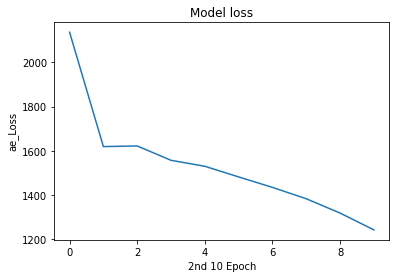

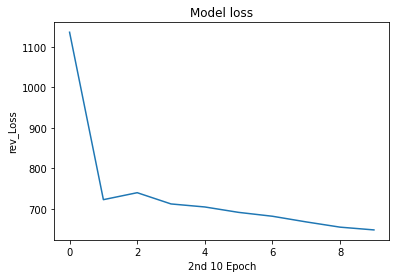

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_20e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_20e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_20e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_100k_20e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_100k_20e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()

### 3rd 10 Epochs


In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_20e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_20e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_20e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K = batch_K/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    1170.65 | Loss Rev     710.88: 100%|██████████| 1563/1563 [11:51<00:00,  2.20it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1013.03 | Loss Rev     612.60: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     977.66 | Loss Rev     586.41: 100%|██████████| 1563/1563 [11:15<00:00,  2.31it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     948.71 | Loss Rev     565.05: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     921.05 | Loss Rev     546.29: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     898.23 | Loss Rev     529.06: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     883.99 | Loss Rev     519.66: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE     876.14 | Loss Rev     512.04: 100%|██████████| 1563/1563 [11:13<00

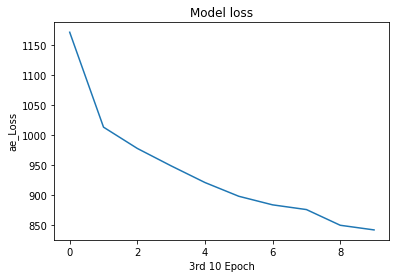

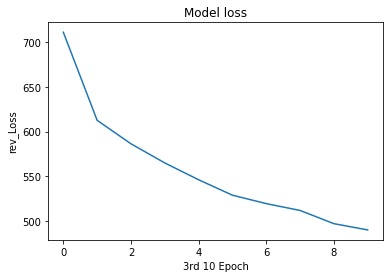

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_30e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_30e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_30e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_100k_30e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_100k_30e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()

### 4th 10 Epochs


In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_30e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_30e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_30e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K = batch_K/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE     905.13 | Loss Rev     535.91: 100%|██████████| 1563/1563 [11:55<00:00,  2.18it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE     826.01 | Loss Rev     478.69: 100%|██████████| 1563/1563 [11:23<00:00,  2.29it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     817.08 | Loss Rev     473.89: 100%|██████████| 1563/1563 [11:23<00:00,  2.29it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     815.26 | Loss Rev     471.46: 100%|██████████| 1563/1563 [11:23<00:00,  2.29it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     824.36 | Loss Rev     473.74: 100%|██████████| 1563/1563 [11:21<00:00,  2.29it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     804.87 | Loss Rev     466.07: 100%|██████████| 1563/1563 [11:20<00:00,  2.30it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     798.46 | Loss Rev     461.25: 100%|██████████| 1563/1563 [11:20<00:00,  2.30it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1068.16 | Loss Rev     624.49: 100%|██████████| 1563/1563 [11:17<00

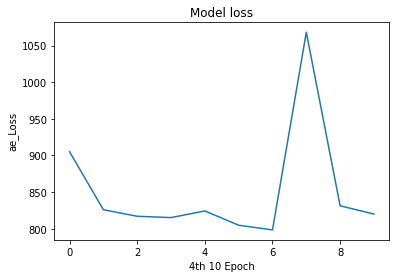

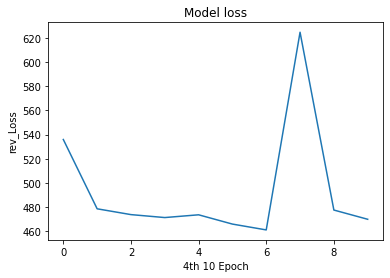

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_40e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_40e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_40e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_100k_40e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_100k_40e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()

### 5th 10 Epochs

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_40e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_40e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_40e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(256, size=(len(batch_S), 64, 64, 3))
          batch_K = batch_K/255.
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE     930.71 | Loss Rev     552.34: 100%|██████████| 1563/1563 [11:48<00:00,  2.21it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE     796.05 | Loss Rev     456.33: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     790.48 | Loss Rev     453.01: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     790.10 | Loss Rev     454.37: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     781.18 | Loss Rev     446.67: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     778.41 | Loss Rev     446.76: 100%|██████████| 1563/1563 [11:13<00:00,  2.32it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     777.67 | Loss Rev     445.55: 100%|██████████| 1563/1563 [11:14<00:00,  2.32it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE     773.41 | Loss Rev     443.64: 100%|██████████| 1563/1563 [11:14<00

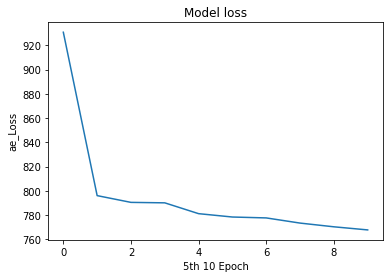

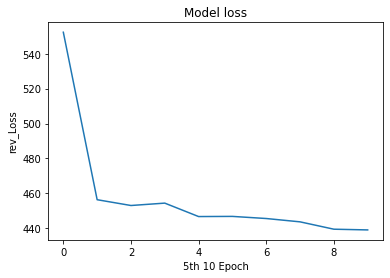

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_50e.hdf5')

with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_100k_50e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_100k_50e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()

### Test 

In [12]:
# S: secret image
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [13]:

input_K = np.random.randint(256, size=(len(input_S), 64, 64, 3))
input_K = input_K/255.

In [14]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_50e.hdf5')

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return rmse_Spixel, rmse_Cpixel

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C, input_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 5.708641
C error per pixel [0, 255]: 7.270917


###Wrong Key


(1, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


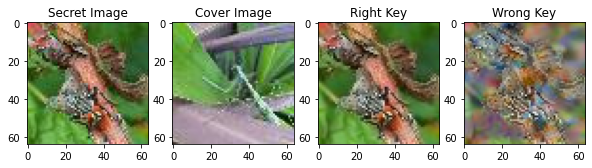

In [34]:
secret=X_test[2]
cover=X_test[3]
test_actual_K = np.random.randint(2, size=(1, 64, 64, 3))
test_wrong_K = np.random.randint(2, size=(1, 64, 64, 3))
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]), test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime, test_wrong_K])

fig, a = plt.subplots(1, 4, figsize=(10, 3))
a[0].imshow(secret)
a[0].set_title('Secret Image')
a[1].imshow(cover)
a[1].set_title('Cover Image')
a[2].imshow(Reveal_actual[0])
a[2].set_title('Right Key')
a[3].imshow(Reveal_wrong[0])
a[3].set_title('Wrong Key')
plt.show()